In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

# fix random seed for reproducibility
import warnings
warnings.filterwarnings("ignore")
np.random.seed(7)

In [2]:
def print_results(y_test, predict, print_acc = False):
    confusion_matrix(y_test, predict)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    F_m = (2 * tp) / (2*tp + fp + fn)
    Acc = (tn + tp) / (tn + tp + fn + fp)
    Sen = tp / (tp + fn)
    Spe = tn / (fp + tn)
    if print_acc: print(f'Accuracy: {Acc:.4f} Sen: {Sen:.4f}  Spe: {Spe:.4f}')
    return np.array([Acc,Sen,Spe]) 



df = pd.ＤataFrame(pd.read_excel('throat_features.xlsx'))
label = df['label'].dropna()
label = label.values
label = label.astype(np.float64)
feature = df[[f'f{i}' for i in range(1,27)]].values
feature_a = scale(feature)

ind = np.where(label==1)[0]
ind = ind[:55]
label = np.delete(label,ind,0)

method_1 = np.zeros((26,3))
method_2 = np.zeros((26,3))
method_3 = np.zeros((26,3))
method_123 = np.zeros((26,3))

for pca_number in range(1,27):

    print(f'K = {pca_number}')
    pca = PCA(pca_number)
    feature_a_x = pca.fit_transform(feature_a)
    feature_a_x = np.delete(feature_a_x,ind,0)

    # Split the datasets into 75% training sets and 25% testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_a_x, label, train_size=0.75, random_state=1,stratify=label)

    # Classified by AdaBoost
    model_1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5), algorithm="SAMME", n_estimators=300, learning_rate=.2)
    model_1.fit(X_train, y_train)
    predict_train_1=model_1.predict(X_train)
    predict_1=model_1.predict(X_test)
    method_1[pca_number-1,:] = print_results(y_test,predict_1,print_acc=False)

    # Classified by SVM
    model = SVC(kernel= 'rbf',random_state = 0,probability=True)
    parameters={'C':np.linspace(0.1,20,50)}
    scoring_fnc = make_scorer(accuracy_score)
    kfold = KFold(n_splits=5)
    grid = GridSearchCV(model, parameters, scoring_fnc, cv=kfold)
    grid_a = grid.fit(X_train, y_train)
    model_2 = grid.best_estimator_
    predict_train_2=model_2.predict(X_train)
    predict_2=model_2.predict(X_test)
    method_2[pca_number-1,:] = print_results(y_test,predict_2,print_acc=False)

    # Classified by MLP 
    model_3 = MLPClassifier(solver='sgd',activation='tanh', max_iter=1000, hidden_layer_sizes=(35,19),random_state=0)
    model_3.fit(X_train, y_train)
    predict_3=model_3.predict(X_test)
    method_3[pca_number-1,:] = print_results(y_test,predict_3,print_acc=False)

    # Classified by integrade
    model_123 = MLPClassifier(solver='sgd',activation='tanh', max_iter=1000, hidden_layer_sizes=(35,19),random_state=0)
    model_123.fit(np.hstack((X_train,predict_train_1[:,np.newaxis],predict_train_2[:,np.newaxis])), y_train)
    predict_123=model_123.predict(np.hstack((X_test,predict_1[:,np.newaxis],predict_2[:,np.newaxis])))
    method_123[pca_number-1,:] = print_results(y_test,predict_123,print_acc=False)


K = 1
K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
K = 20
K = 21
K = 22
K = 23
K = 24
K = 25
K = 26


Maximum of Acc = 0.6977 0.6512 0.6744 0.7209
Good Result:  11
Bad Result :  0


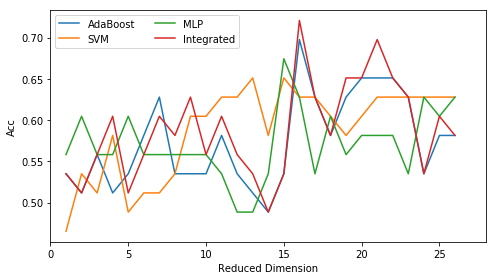

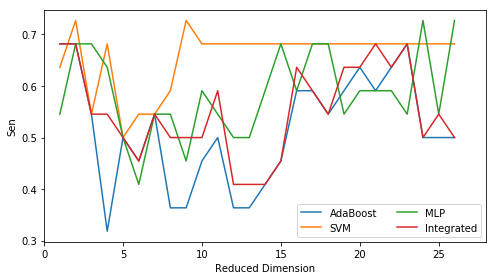

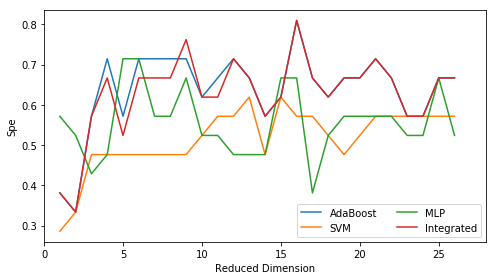

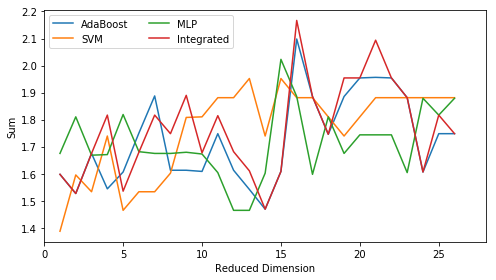

In [3]:
Acc = np.stack((method_1[:,0],method_2[:,0],method_3[:,0],method_123[:,0]), axis=1)
Sen = np.stack((method_1[:,1],method_2[:,1],method_3[:,1],method_123[:,1]), axis=1)
Spe = np.stack((method_1[:,2],method_2[:,2],method_3[:,2],method_123[:,2]), axis=1)
print(f'Maximum of Acc = {np.max(Acc[:,0]):.4f} {np.max(Acc[:,1]):.4f} {np.max(Acc[:,2]):.4f} {np.max(Acc[:,3]):.4f}')
print('Good Result: ', sum(Acc[:,3] >= Acc[:,0:3].max(axis=1)))  
print('Bad Result : ', sum(Acc[:,3] < Acc[:,0:3].min(axis=1)))  

plt.figure(figsize=(7,4))
plt.plot(np.arange(1,27), Acc[:,0], label='AdaBoost')
plt.plot(np.arange(1,27), Acc[:,1], label='SVM')
plt.plot(np.arange(1,27), Acc[:,2], label='MLP')
plt.plot(np.arange(1,27), Acc[:,3], label='Integrated')
plt.xlim((0,28))
plt.ylabel('Acc')
plt.xlabel('Reduced Dimension')
plt.legend(loc='bottom right',ncol=2)
plt.tight_layout()
# plt.savefig('Acc.pdf', bbox_inches='tight')

plt.figure(figsize=(7,4))
plt.plot(np.arange(1,27), Sen[:,0], label='AdaBoost')
plt.plot(np.arange(1,27), Sen[:,1], label='SVM')
plt.plot(np.arange(1,27), Sen[:,2], label='MLP')
plt.plot(np.arange(1,27), Sen[:,3], label='Integrated')
plt.xlim((0,28))
plt.ylabel('Sen')
plt.xlabel('Reduced Dimension')
plt.legend(loc='bottom left',ncol=2)
plt.tight_layout()
# plt.savefig('Sen.pdf', bbox_inches='tight')

plt.figure(figsize=(7,4))
plt.plot(np.arange(1,27), Spe[:,0], label='AdaBoost')
plt.plot(np.arange(1,27), Spe[:,1], label='SVM')
plt.plot(np.arange(1,27), Spe[:,2], label='MLP')
plt.plot(np.arange(1,27), Spe[:,3], label='Integrated')
plt.xlim((0,28))
plt.ylabel('Spe')
plt.xlabel('Reduced Dimension')
plt.legend(loc='bottom right',ncol=2)
plt.tight_layout()
# plt.savefig('Spe.pdf', bbox_inches='tight')

plt.figure(figsize=(7,4))
plt.plot(np.arange(1,27), Acc[:,0]+Sen[:,0]+Spe[:,0], label='AdaBoost')
plt.plot(np.arange(1,27), Acc[:,1]+Sen[:,1]+Spe[:,1], label='SVM')
plt.plot(np.arange(1,27), Acc[:,2]+Sen[:,2]+Spe[:,2], label='MLP')
plt.plot(np.arange(1,27), Acc[:,3]+Sen[:,3]+Spe[:,3], label='Integrated')
plt.xlim((0,28))
plt.ylabel('Sum')
plt.xlabel('Reduced Dimension')
plt.legend(loc='bottom right',ncol=2)
plt.tight_layout()
# plt.savefig('Sum.pdf', bbox_inches='tight')